In [1]:
# pip install pandas scikit-learn matplotlib

In [2]:
from pathlib import Path
import os

import utils as u

In [3]:
notebook_path = Path(os.path.abspath("."))
data_path = notebook_path.parent / "docs" / "data"

# EVALUATION

## NHL

In [4]:
prediction_files, results_files = u.get_prediction_results_filepaths(league="nhl", root=data_path)

df = u.make_dataframe(pred_filepaths=prediction_files, res_filepaths=results_files, total_line=6.5, hcp_line=1.5)
df.head(2)

,match_id,start_time_utc,home_team,away_team,ft_home_prob,ou_prob,hcp_prob,home_team_score,away_team_score,ft_home_won,ou_won,hcp_won
0,2025020338,2025-11-23T00:00:00,Florida Panthers,Edmonton Oilers,0.5131,0.4313,0.7395,3,6,False,True,False
1,2025020158,2025-10-29T00:15:00,St. Louis Blues,Detroit Red Wings,0.5611,0.4040,0.7829,2,5,False,True,False


=== Evaluation Summary ===
                       n  prevalence  brier  logloss    auc  acc@0.5
metric                                                              
FT Home Win          356      0.5309 0.2556   0.7048 0.5080   0.5140
Totals (Over/Under)  356      0.4831 0.2511   0.6953 0.5019   0.5253
Asian Handicap       356      0.7584 0.1893   0.5691 0.4963   0.7556


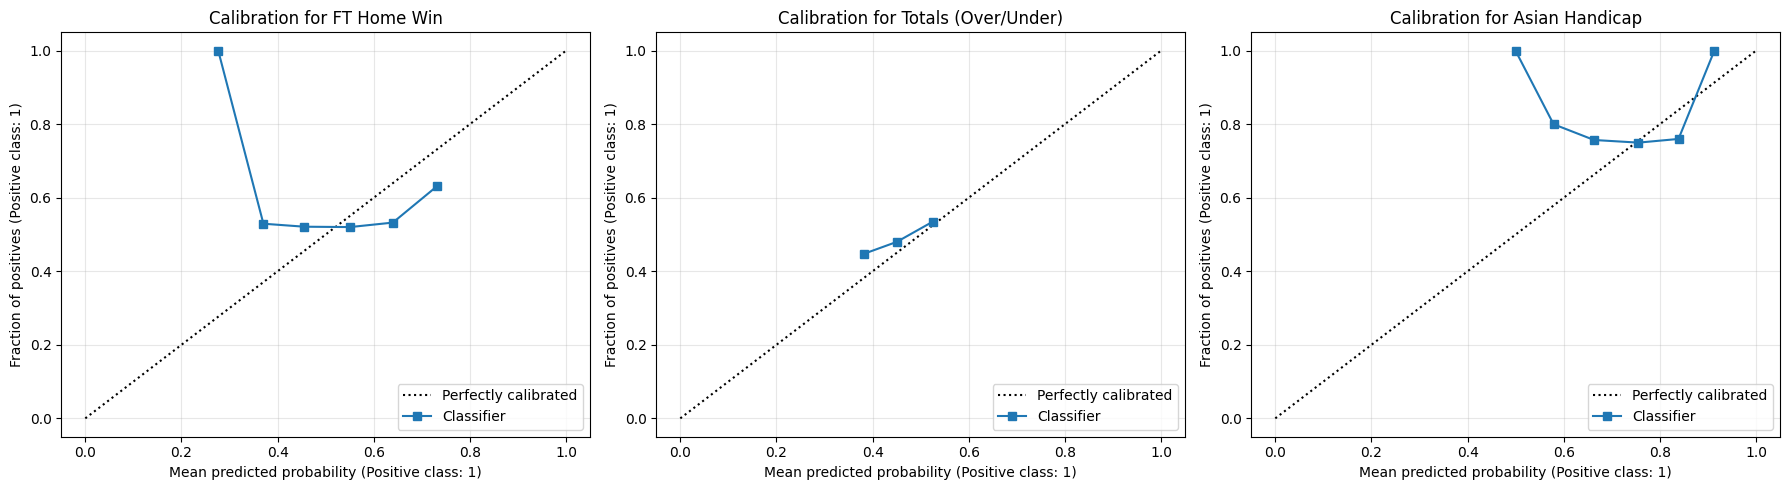

In [5]:
# Evaluate everything
_ = u.evaluate_calibration(df=df, n_bins=10)

=== Evaluation Summary ===
                       n  prevalence  brier  logloss    auc  acc@0.5
metric                                                              
FT Home Win          216      0.5324 0.2525   0.6977 0.5263   0.5093
Totals (Over/Under)  216      0.4907 0.2516   0.6962 0.4980   0.5046
Asian Handicap       216      0.7593 0.1925   0.5755 0.4623   0.7546


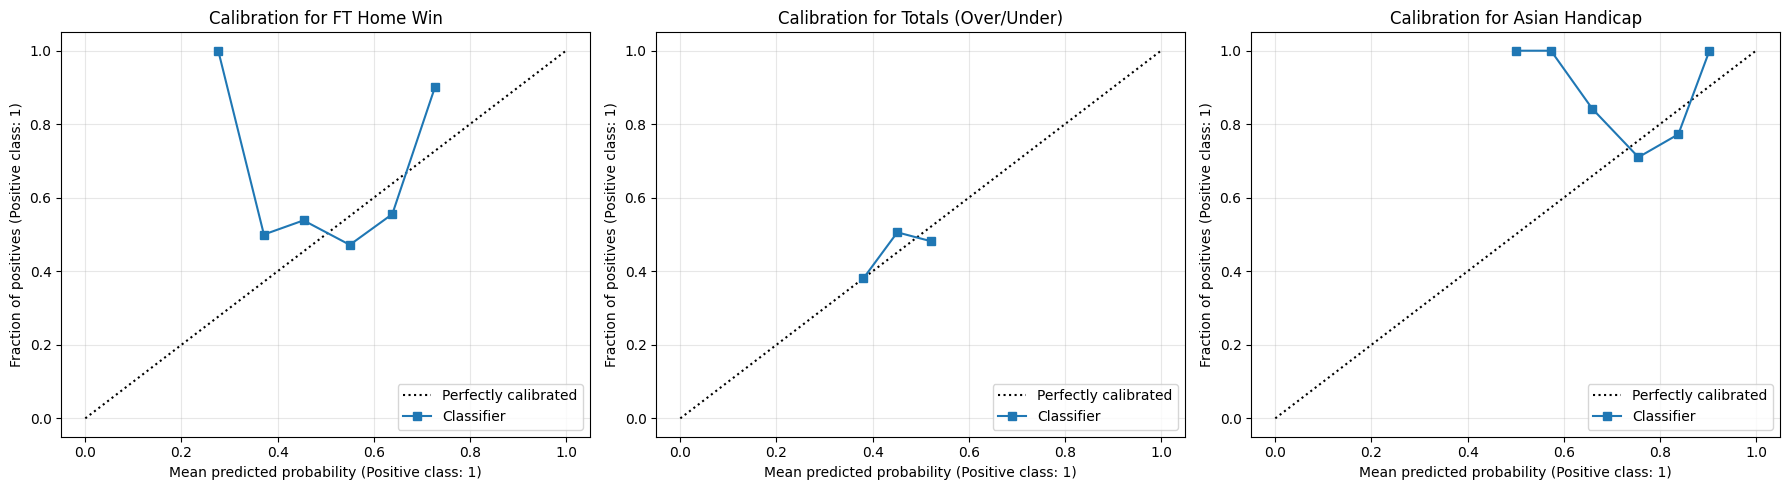

In [6]:
# Evaluate matches only after major bugfix
after_bug_df = df[df["start_time_utc"]>="2025-10-29 15:00:00"].copy()
_ = u.evaluate_calibration(df=after_bug_df, n_bins=10)

## NBA

In [7]:
prediction_files, results_files = u.get_prediction_results_filepaths(league="nba", root=data_path)

df = u.make_dataframe(pred_filepaths=prediction_files, res_filepaths=results_files, total_line=225.5, hcp_line=8.5)
df.head(2)

,match_id,start_time_utc,home_team,away_team,ft_home_prob,ou_prob,hcp_prob,home_team_score,away_team_score,ft_home_won,ou_won,hcp_won
0,0022500264,2025-11-21T00:00:00,Orlando Magic,Los Angeles Clippers,0.3465,0.3498,0.5706,129,101,True,True,True
1,0022500067,2025-11-27T03:00:00,Portland Trailblazers,San Antonio Spurs,0.5471,0.7181,0.7488,102,115,False,False,False


=== Evaluation Summary ===
                      n  prevalence  brier  logloss    auc  acc@0.5
metric                                                             
FT Home Win          84      0.5476 0.2041   0.5906 0.7431   0.6310
Totals (Over/Under)  84      0.5952 0.2589   0.7214 0.5321   0.5833
Asian Handicap       84      0.7500 0.1484   0.4492 0.8065   0.7738


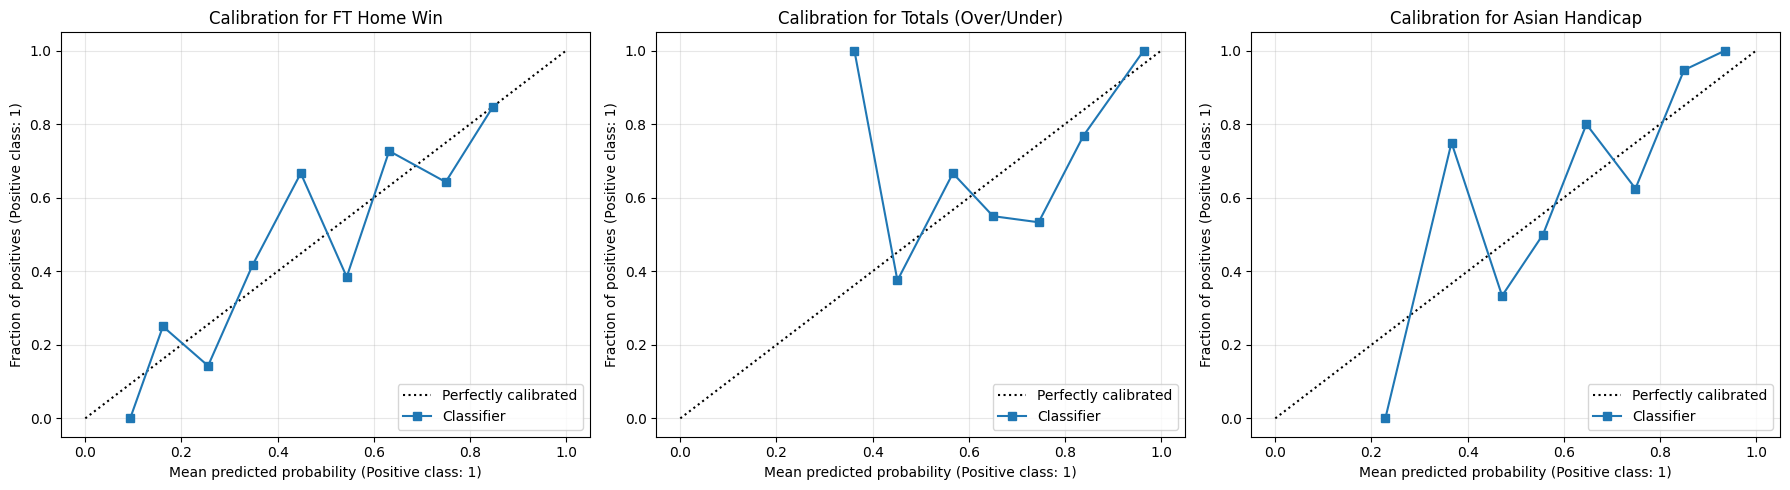

In [8]:
_ = u.evaluate_calibration(df=df, n_bins=10)